# Customer Churn Prediction

#### Importing require libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import f1_score


#### Reading the dataset

In [17]:
churn_data = pd.read_csv('Group 1.csv').drop(['Unnamed: 0'],axis =1)
churn_data = churn_data.drop_duplicates(subset = ['customer_id'])  # Dropping duplictes
churn_data.head()

,customer_id,gender,location,partner,dependents,senior,Tenure,monthly_cost,package,survey,Class
0,G1606,Female,Lancashire,0,1,0,20.0,NaN,2,0,Churn=No
1,F8889,Female,Essex,0,1,0,4.0,NaN,1,5,Churn=No
2,C5068,Female,Essex,0,Unknown,1,9.0,NaN,2,0,Churn=No
3,G9820,Male,West Yorkshire,1,1,1,9.0,NaN,4,9,Churn=No
4,H7261,Male,Greater Manchester,0,1,0,6.0,NaN,2,5,Churn=No


In [18]:
#Exploring datatypes and null values of each column
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6770 entries, 0 to 7349
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customer_id   6770 non-null   object 
 1   gender        6770 non-null   object 
 2   location      6770 non-null   object 
 3   partner       6770 non-null   int64  
 4   dependents    6770 non-null   object 
 5   senior        6770 non-null   int64  
 6   Tenure        6770 non-null   float64
 7   monthly_cost  75 non-null     object 
 8   package       6770 non-null   int64  
 9   survey        6770 non-null   object 
 10  Class         6715 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 634.7+ KB


#### Data Cleaning 

In [19]:
#drop rows which do not have class label
churn_data = churn_data.dropna(subset = ['Class'])

In [20]:
churn_data['Class'].value_counts()

Churn=No     4787
Churn=Yes    1909
Y$e$s$$        19
Name: Class, dtype: int64

In [21]:
# Cleaning the Class column and converting into binary format
churn_data['Class'] = np.where(churn_data['Class'] == 'Churn=Yes',1,np.where(churn_data['Class'] == 'Y$e$s$$',1,0))
churn_data['Class'].value_counts()

0    4787
1    1928
Name: Class, dtype: int64

In [23]:
#Replacing the values in the columns monthly_cost, discount_col, updated_monthly_cost.

churn_data['monthly_cost'] = np.where(churn_data['package'] == 1,26,np.where(churn_data['package'] == 2,34,
                                                                 np.where(churn_data['package'] == 3,40,
                                                                          np.where(churn_data['package'] == 4,46,0))))


churn_data['discount_col'] = np.where(churn_data['Tenure'] <=25, churn_data['monthly_cost']*((churn_data['Tenure']*2)/100),
                            churn_data['monthly_cost']*(0.50))

churn_data['updated_monthly_cost'] = churn_data['monthly_cost']-churn_data['discount_col']


In [24]:
churn_data = churn_data.drop(['discount_col','monthly_cost'],axis = 1)

In [25]:
churn_data.head()

,customer_id,gender,location,partner,dependents,senior,Tenure,package,survey,Class,updated_monthly_cost
0,G1606,Female,Lancashire,0,1,0,20.0,2,0,0,20.40
1,F8889,Female,Essex,0,1,0,4.0,1,5,0,23.92
2,C5068,Female,Essex,0,Unknown,1,9.0,2,0,0,27.88
3,G9820,Male,West Yorkshire,1,1,1,9.0,4,9,0,37.72
4,H7261,Male,Greater Manchester,0,1,0,6.0,2,5,0,29.92


In [26]:
churn_data['gender'] = churn_data['gender'].replace({'Male':1,'Female':0}) #Replacing Male with 1 and female with 0
churn_data['gender'].value_counts()

0    3310
1    3282
Name: gender, dtype: int64

In [27]:
# Treating null values in survey column
churn_data['survey'] = churn_data['survey'].replace('No reply',5).astype(str).astype(int)

In [28]:
# Removing records with -ve values in tenure
churn_data = churn_data[churn_data['Tenure'] >= 0]

In [29]:
churn_data['dependents'].value_counts()

1          3177
Unknown    1973
0          1442
Name: dependents, dtype: int64

#### Splitting the Dataset for train and test

In [30]:
# Filter rows where 'dependents' is known and convert to binary (1 or 0)
churn_data_impu_data = churn_data[churn_data['dependents'] != 'Unknown']
churn_data_impu_data['dependents'] = np.where(churn_data_impu_data['dependents'] == '1', 1, 0)

# Drop unnecessary columns
churn_data_impu_data = churn_data_impu_data.drop(['customer_id', 'location'], axis=1)

# Separate rows where 'dependents' is 'Unknown' for prediction
churn_data_impu_data_test = churn_data[churn_data['dependents'] == 'Unknown'].drop(['dependents', 'customer_id', 'location'], axis=1)

# Split known data for model training and validation
X = churn_data_impu_data.drop(['dependents'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, churn_data_impu_data['dependents'], test_size=0.35)

# Train a logistic regression model and predict 'dependents' for 'Unknown' rows
log_reg = LogisticRegression(random_state=0).fit(X_train, y_train)
churn_data_impu_data_test['y_pred'] = log_reg.predict(churn_data_impu_data_test[['gender', 'partner', 'senior', 'Tenure', 'updated_monthly_cost', 'package', 'survey', 'Class']])

# Merge predicted 'dependents' back into the original data
churn_data_impu_data_test_updated_data = pd.merge(churn_data, churn_data_impu_data_test[['y_pred']], how='left', left_index=True, right_index=True)

# Update 'dependents' for 'Unknown' rows with predicted values and drop 'y_pred'
churn_data_impu_data_test_updated_data['dependents'] = np.where(churn_data_impu_data_test_updated_data['dependents'] == 'Unknown',
    round(churn_data_impu_data_test_updated_data['y_pred'], 0), churn_data_impu_data_test_updated_data['dependents']).astype(float)
churn_data_impu_data_test_updated_data = churn_data_impu_data_test_updated_data.drop('y_pred', axis=1)


In [31]:
churn_data_impu_data_test_updated_data['dependents'].value_counts()
data = churn_data_impu_data_test_updated_data.copy()

# Exploratory data analysis

In [32]:
data.head()
data['Class'] = np.where(data['Class'] == 0,"Churn=No",'Churn=Yes')

In [33]:
data.describe()

,gender,partner,dependents,senior,Tenure,package,survey,updated_monthly_cost
count,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000
mean,0.497876,0.548089,0.481948,0.167779,8.886377,2.376820,4.725728,29.206572
std,0.500033,0.497720,0.499712,0.373698,6.178082,1.164251,2.287423,7.281482
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,13.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,3.000000,23.920000
50%,0.000000,1.000000,0.000000,0.000000,9.000000,2.000000,5.000000,28.560000
75%,1.000000,1.000000,1.000000,0.000000,13.000000,4.000000,6.000000,34.000000
max,1.000000,1.000000,1.000000,1.000000,30.000000,4.000000,10.000000,46.000000


In [34]:
numeric_col = ['Tenure','survey','updated_monthly_cost','package']

In [35]:
cat_col = ['gender','partner','dependents','senior']

#### Customer churn plot based on the type package

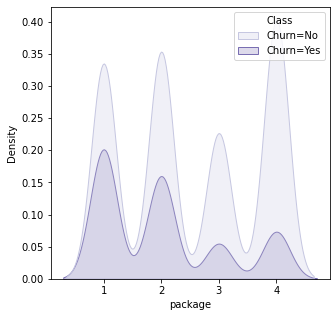

In [23]:
plt.figure(figsize=(5,5))
sns.kdeplot(data = data, x= "package", hue = "Class",palette ='Purples',shade = True)
plt.show()

#### Customer churn plot based on the Survey

<AxesSubplot:xlabel='survey', ylabel='count'>

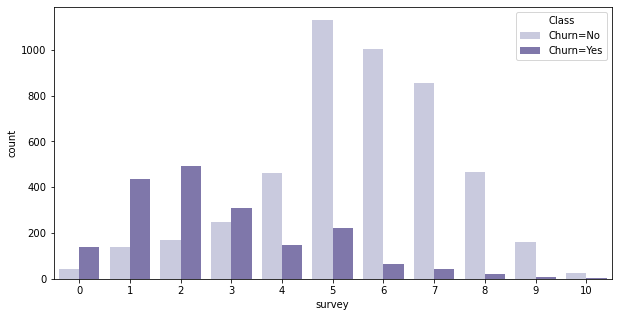

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(data=data, x='survey',hue = "Class",palette ='Purples')


#### Customer churn plot based on the monthly_cost

<AxesSubplot:xlabel='updated_monthly_cost', ylabel='Count'>

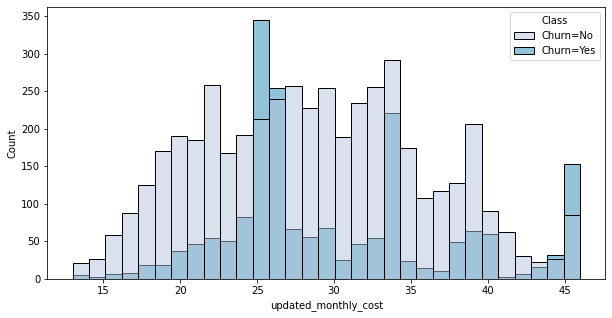

In [25]:
plt.figure(figsize=(10,5))
sns.histplot(data=data, x='updated_monthly_cost',hue = "Class",palette ='PuBuGn')


#### Customer churn plot based on the tenure 

<AxesSubplot:xlabel='Tenure', ylabel='Density'>

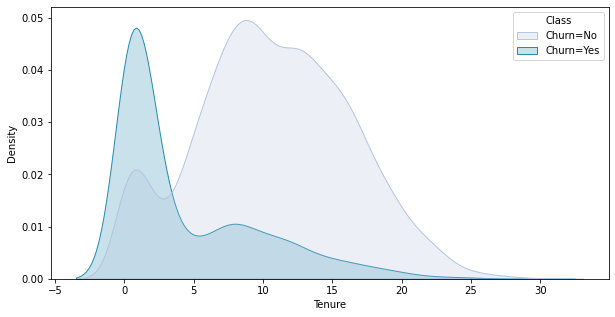

In [42]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=data, x='Tenure',hue = "Class",palette ='PuBuGn',shade=True)

####  Customer churn plot based on the users gender

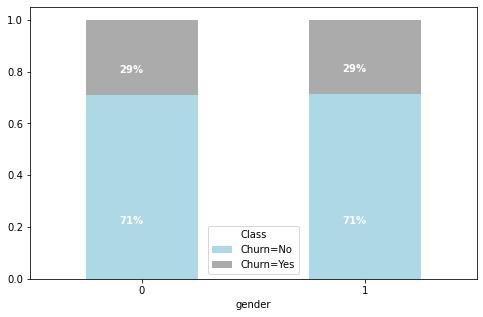

In [27]:
gender_col = data.groupby(['gender', 'Class']).size().unstack()
gender_col = gender_col.T / gender_col.T.sum()  
fig = gender_col.T.plot(kind='bar', stacked=True, rot=0, color=['#ADD8E6', '#ABABAB'], figsize=(8,5))

for patch in fig.patches:
    width, height = patch.get_width(), patch.get_height()
    x, y = patch.get_xy()
    # value, (x, y)
    fig.annotate('{}%'.format(round(height * 100)), (x+0.3*width, y+0.3*height), color='white', weight='bold')

#### Customer churn plot when the user has dependents

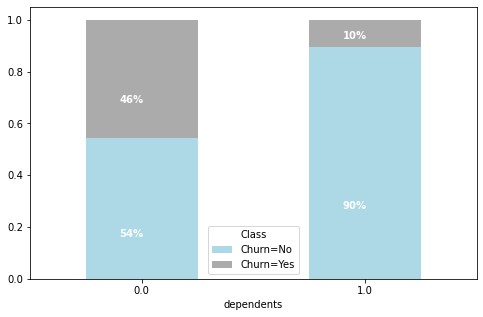

In [28]:
gender_col = data.groupby(['dependents', 'Class']).size().unstack()
gender_col = gender_col.T / gender_col.T.sum()  
fig = gender_col.T.plot(kind='bar', stacked=True, rot=0, color=['#ADD8E6', '#ABABAB'], figsize=(8,5))

for patch in fig.patches:
    width, height = patch.get_width(), patch.get_height()
    x, y = patch.get_xy()
    # value, (x, y)
    fig.annotate('{}%'.format(round(height * 100)), (x+0.3*width, y+0.3*height), color='white', weight='bold')

#### Customer churn plot when the user is a senior citizen

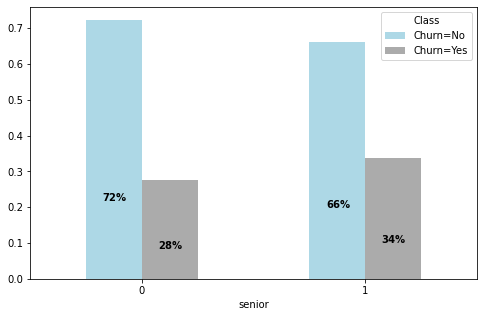

In [29]:
gender_col = data.groupby(['senior', 'Class']).size().unstack()
gender_col = gender_col.T / gender_col.T.sum()  
fig = gender_col.T.plot(kind='bar', rot=0, color=['#ADD8E6', '#ABABAB'], figsize=(8,5))

for patch in fig.patches:
    width, height = patch.get_width(), patch.get_height()
    x, y = patch.get_xy()
    fig.annotate('{}%'.format(round(height * 100)), (x+0.3*width, y+0.3*height), color='black', weight='bold')

#### Customer churn plot when the user has a partner

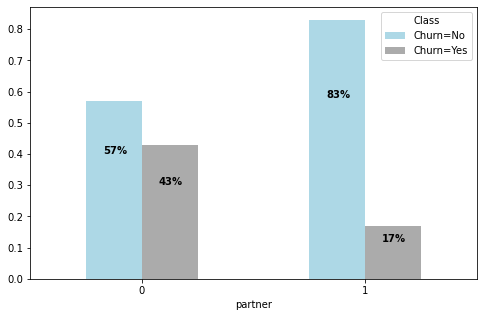

In [30]:

gender_col = data.groupby(['partner', 'Class']).size().unstack()
gender_col = gender_col.T / gender_col.T.sum()  
fig = gender_col.T.plot(kind='bar', rot=0, color=['#ADD8E6', '#ABABAB'], figsize=(8,5))

for patch in fig.patches:
    width, height = patch.get_width(), patch.get_height()
    x, y = patch.get_xy()
    fig.annotate('{}%'.format(round(height * 100)), (x+0.3*width, y+0.7*height), color='Black', weight='bold')

# Predictor Variable (Churn)

#### Class variable Distribution

In [31]:
data.head()

,customer_id,gender,location,partner,dependents,senior,Tenure,package,survey,Class,updated_monthly_cost
0,G1606,0,Lancashire,0,1.0,0,20.0,2,0,Churn=No,20.40
1,F8889,0,Essex,0,1.0,0,4.0,1,5,Churn=No,23.92
2,C5068,0,Essex,0,0.0,1,9.0,2,0,Churn=No,27.88
3,G9820,1,West Yorkshire,1,1.0,1,9.0,4,9,Churn=No,37.72
4,H7261,1,Greater Manchester,0,1.0,0,6.0,2,5,Churn=No,29.92


In [32]:
data['Class'] = np.where(data['Class'] =='Churn=No',0,1 )

In [33]:
data['Class'].value_counts()

0    4697
1    1895
Name: Class, dtype: int64

#### Tenure vs Churn

<AxesSubplot:xlabel='Class', ylabel='Tenure'>

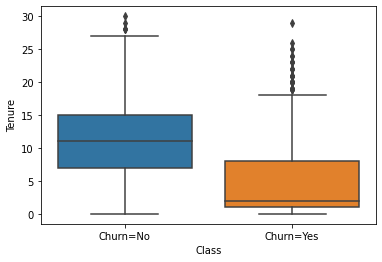

In [44]:
sns.boxplot(x = data['Class'], y = data.Tenure)

#### Location vs Churn

In [36]:
data.head()

,customer_id,gender,location,partner,dependents,senior,Tenure,package,survey,Class,updated_monthly_cost
0,G1606,0,Lancashire,0,1.0,0,20.0,2,0,0,20.40
1,F8889,0,Essex,0,1.0,0,4.0,1,5,0,23.92
2,C5068,0,Essex,0,0.0,1,9.0,2,0,0,27.88
3,G9820,1,West Yorkshire,1,1.0,1,9.0,4,9,0,37.72
4,H7261,1,Greater Manchester,0,1.0,0,6.0,2,5,0,29.92


<AxesSubplot:title={'center':'Distribution of Location'}, xlabel='location', ylabel='counts'>

<Figure size 720x432 with 0 Axes>

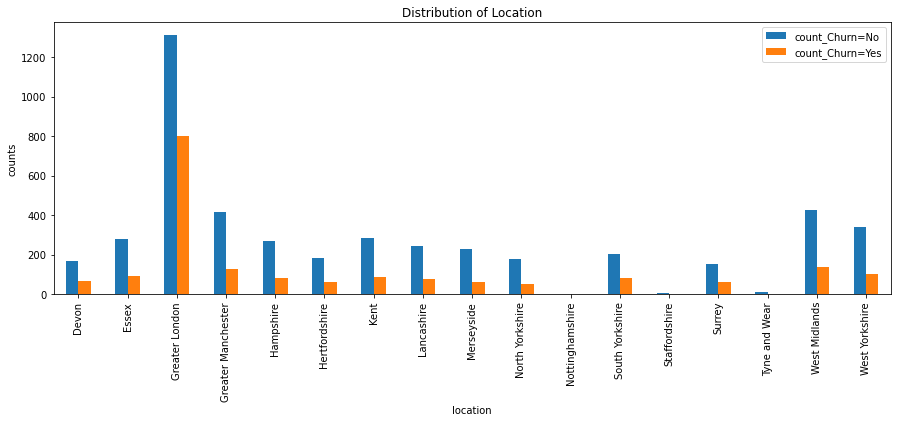

In [45]:
loc = data.groupby(['location','Class'])["customer_id"].count().reset_index(name="count")
loc = loc.pivot_table(index=["location"], columns='Class',values=["count"], aggfunc='first')
loc = loc.sort_index(axis=1, level=1)
loc.columns = loc.columns.map('{0[0]}_{0[1]}'.format) 
loc = loc.reset_index(level=0)
plt.figure(figsize=(10, 6))
loc = loc.set_index('location')
loc.plot(kind = 'bar',title="Distribution of Location",xlabel='location',ylabel="counts",figsize = (15,5))


#### Seniority Level vs Churn

In [38]:
data.head()

,customer_id,gender,location,partner,dependents,senior,Tenure,package,survey,Class,updated_monthly_cost
0,G1606,0,Lancashire,0,1.0,0,20.0,2,0,0,20.40
1,F8889,0,Essex,0,1.0,0,4.0,1,5,0,23.92
2,C5068,0,Essex,0,0.0,1,9.0,2,0,0,27.88
3,G9820,1,West Yorkshire,1,1.0,1,9.0,4,9,0,37.72
4,H7261,1,Greater Manchester,0,1.0,0,6.0,2,5,0,29.92


In [39]:
data.columns

Index(['customer_id', 'gender', 'location', 'partner', 'dependents', 'senior',
       'Tenure', 'package', 'survey', 'Class', 'updated_monthly_cost'],
      dtype='object')

In [40]:
data = data.drop('customer_id',axis = 1)

#### Building Correlation plot

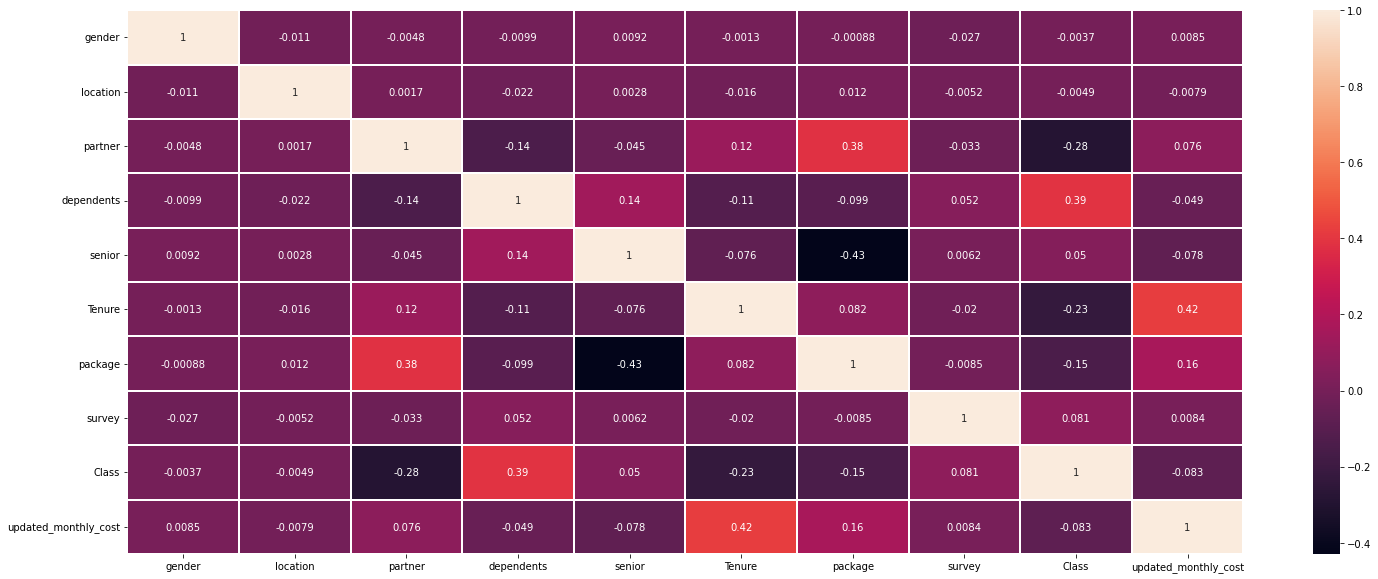

In [41]:
plt.figure(figsize=(25, 10))

corr = data.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2)

# Onehot Encoding

In [42]:
location_dummies = pd.get_dummies(data.location)
data1 = pd.concat([data, location_dummies], axis=1)
data1 = data1.drop(['location'],axis = 1)
data1["Class"] = data1["Class"].replace({'Churn=No':0, 'Churn=Yes': 1})

x = data1[[i for i in data1.columns if i not in "Class"]]
Y = data1[['Class']]

In [43]:
data1.head()

,gender,partner,dependents,senior,Tenure,package,survey,Class,updated_monthly_cost,Devon,...,Lancashire,Merseyside,North Yorkshire,Nottinghamshire,South Yorkshire,Staffordshire,Surrey,Tyne and Wear,West Midlands,West Yorkshire
0,0,0,1.0,0,20.0,2,0,0,20.40,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,1.0,0,4.0,1,5,0,23.92,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0.0,1,9.0,2,0,0,27.88,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1.0,1,9.0,4,9,0,37.72,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,1.0,0,6.0,2,5,0,29.92,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
data1['Class'].value_counts()

0    4697
1    1895
Name: Class, dtype: int64

In [45]:
X_res, y_res = RandomOverSampler().fit_resample(x, Y)
data1 = pd.concat([X_res, y_res],axis=1)
data1.shape
data1['Class'].value_counts()

0    4697
1    4697
Name: Class, dtype: int64

# Standardising the Data

In [46]:
from sklearn import preprocessing

X_val = data1.drop('Class', axis=1)
Y = data1['Class']

scaler = preprocessing.MinMaxScaler()
names = X_val.columns
d = scaler.fit_transform(X_val)
scaled_df = pd.DataFrame(d, columns=names)
scaled_df.head()



,gender,partner,dependents,senior,Tenure,package,survey,updated_monthly_cost,Devon,Essex,...,Lancashire,Merseyside,North Yorkshire,Nottinghamshire,South Yorkshire,Staffordshire,Surrey,Tyne and Wear,West Midlands,West Yorkshire
0,0.0,0.0,1.0,0.0,0.666667,0.333333,0.0,0.224242,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.133333,0.000000,0.5,0.330909,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.300000,0.333333,0.0,0.450909,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.300000,1.000000,0.9,0.749091,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.200000,0.333333,0.5,0.512727,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Building Model Phase

In [47]:
X_train,X_test,y_train,y_test=train_test_split(X_val,Y,test_size=0.25,random_state=351)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7045, 25)
(7045,)
(2349, 25)
(2349,)


              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1182
           1       0.86      0.85      0.85      1167

    accuracy                           0.85      2349
   macro avg       0.85      0.85      0.85      2349
weighted avg       0.85      0.85      0.85      2349



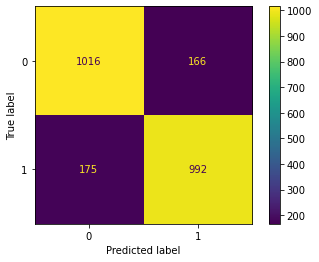

In [48]:
from sklearn.svm import SVC  
from sklearn.metrics import plot_confusion_matrix
svclassifier = SVC(kernel='linear', degree=8)  
clf = svclassifier.fit(X_train, y_train) 
y_pred = clf.predict(X_test)  
from sklearn.metrics import classification_report, confusion_matrix  
print(classification_report(y_test,y_pred))  
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1182
           1       0.93      0.96      0.94      1167

    accuracy                           0.94      2349
   macro avg       0.94      0.94      0.94      2349
weighted avg       0.94      0.94      0.94      2349



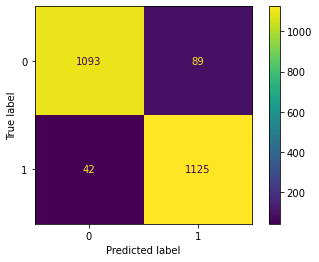

In [50]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

forest_madel = forest.fit(X_train,y_train)
y_pred=forest_madel.predict(X_test)

print(classification_report(y_test,y_pred))  
plot_confusion_matrix(forest_madel, X_test, y_test)  
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1182
           1       0.86      0.85      0.85      1167

    accuracy                           0.86      2349
   macro avg       0.86      0.86      0.86      2349
weighted avg       0.86      0.86      0.86      2349



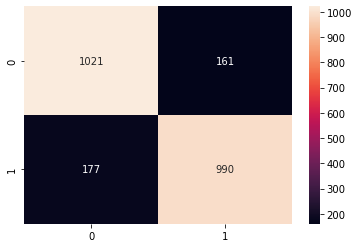

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

Logistic_regression = LogisticRegression(random_state =42)
logit = Logistic_regression.fit(X_train, y_train)

y_pred = logit.predict(X_test)


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1182
           1       0.86      0.85      0.85      1167

    accuracy                           0.86      2349
   macro avg       0.86      0.86      0.86      2349
weighted avg       0.86      0.86      0.86      2349



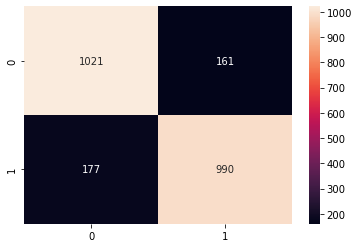

In [52]:

from sklearn.tree import DecisionTreeClassifier
Tree_Classifier = DecisionTreeClassifier()

D_tree = Tree_Classifier.fit(X_train, y_train)

y_pred = logit.predict(X_test)


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')